In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from itertools import product
from multiprocessing import Pool

import seaborn as sns

sns.set_style('white')
sns.set_palette(sns.color_palette('viridis'))

def figsize(scale=1.0):
    latex_width = 418.25555 #pt
    fig_width = latex_width/72.27 # inches
    fig_height = fig_width * (np.sqrt(5)-1.0)/2.0
    return [fig_width*scale, fig_height*scale]

params = {
    'font.size': 11,
    'font.family': 'serif',
    'font.serif': [],
    'axes.labelsize': 11,
    'legend.fontsize': 11,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'figure.figsize': figsize(scale=1.0),
    'text.usetex': True,
    'pgf.texsystem': 'pdflatex',
    'text.latex.unicode': True
    }
plt.rcParams.update(params)
plt.rcParams['text.latex.preamble'].extend([r'\usepackage{amsmath}'])

In [252]:
# Sanity check
directions_3d = [[0,0,1], [0,1,0], [1,0,0], [0,0,-1], [0,-1,0], [-1, 0, 0]]
directions_3d = np.array([np.array(d) for d in directions_3d])

def choose(array):
    """Choose a random element from an array."""
    # np.random.choice doesn't work with 2d-array :(
    idx = np.random.randint(0, len(array))
    return array[idx]

cube_len = 30
steps = 600
n_simul = 2000
displacements = np.zeros((n_simul, steps))
for i in range(n_simul):
    initial_pos = np.array([15, 15, 15])
    cur_pos = initial_pos
    for j in range(steps):
        direction = choose(directions_3d)
        cur_pos = np.mod(cur_pos + direction, cube_len)
        displacements[i, j] = np.linalg.norm(initial_pos - cur_pos)

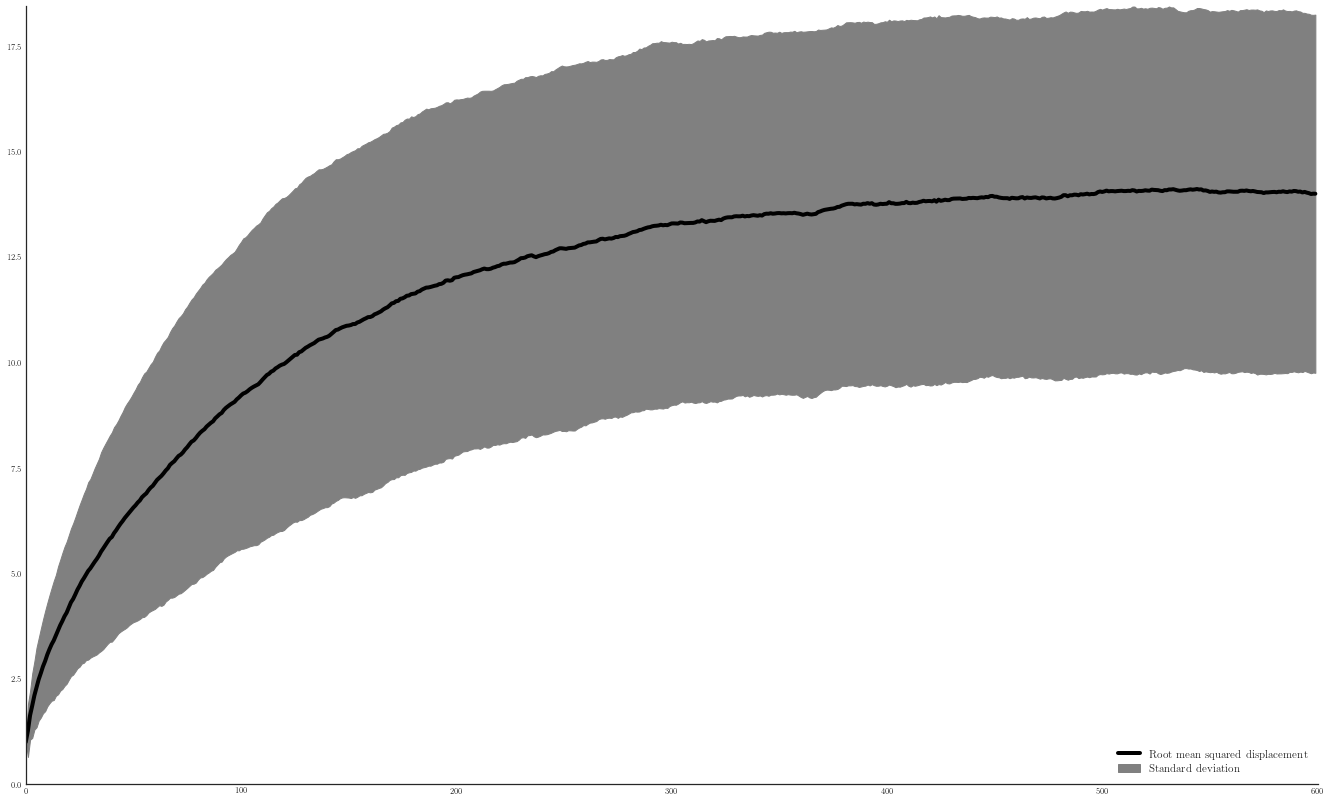

In [254]:
x = range(steps)
y = np.mean(displacements, axis=0)
y_err = np.std(displacements, axis=0)
fig, ax = plt.subplots(figsize=figsize(4))
ax.plot(x, y, c='black', linewidth=4, label='Root mean squared displacement')
#a.plot(x, y_err)
ax.fill_between(x, y, y + y_err, color='grey', label='Standard deviation')
ax.fill_between(x, y - y_err, y, color='grey')
ax.set_xlim(0, steps)
ax.set_ylim(0, (y + y_err).max())
sns.despine(fig)
ax.legend(loc='lower right')
fig.savefig('msd.png', transparent=True, bbox_inches='tight')

In [223]:
y.max(), np.sqrt((2/5)*3*15**2)

(14.257845778923901, 16.431676725154986)

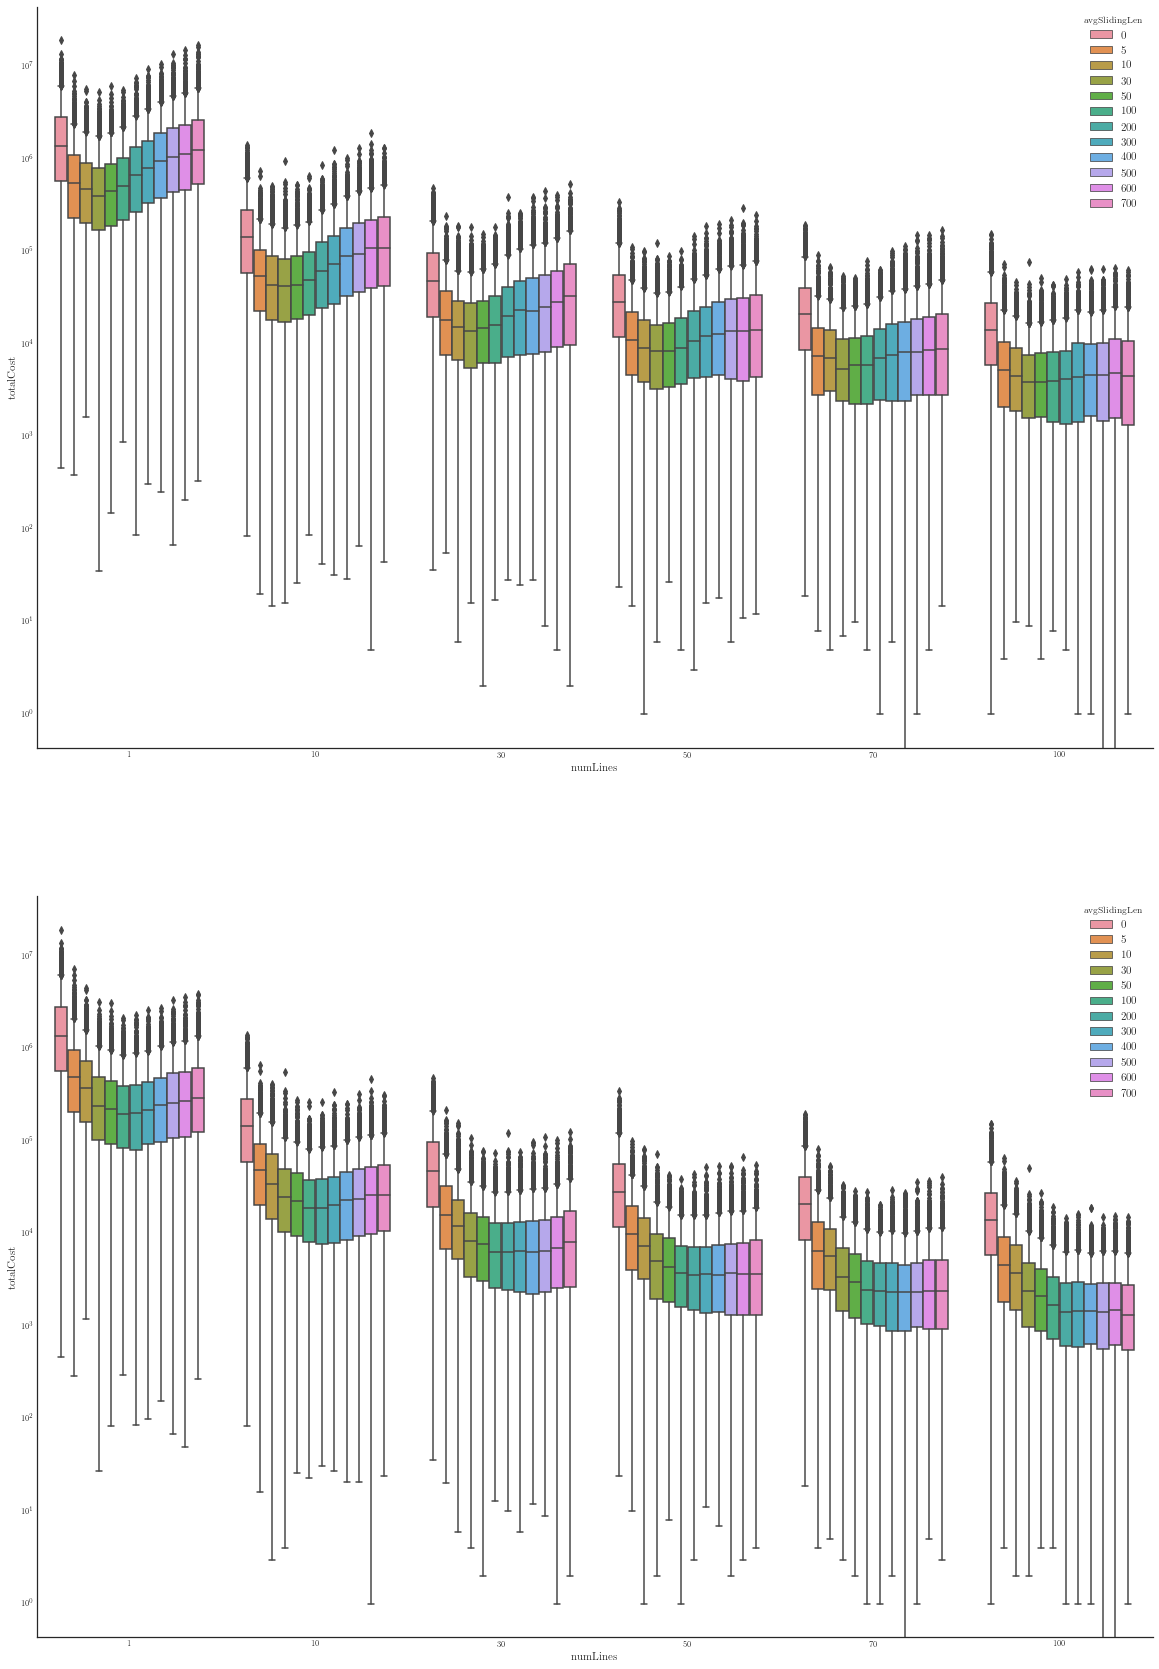

In [246]:
df = pd.read_csv('../results.csv')
weighting_factor = 5 
df['totalCost'] = weighting_factor * df['iterations1D'] + df['iterations3D']
dff = df.loc[df['avgSlidingLen'] < 800]

fig, ax = plt.subplots(2,1, figsize=(20,30))

sns.boxplot(x='numLines', y='totalCost', hue='avgSlidingLen', data=dff, ax=ax[0])
ax[0].set_yscale('log')


weighting_factor = 1
df['totalCost'] = weighting_factor * df['iterations1D'] + df['iterations3D']
dff = df.loc[ df['avgSlidingLen'] < 800]

sns.boxplot(x='numLines', y='totalCost', hue='avgSlidingLen', data=dff, ax=ax[1])
ax[1].set_yscale('log')
sns.despine(fig)
fig.savefig('results.png', bbox_inches='tight', transparent=True)

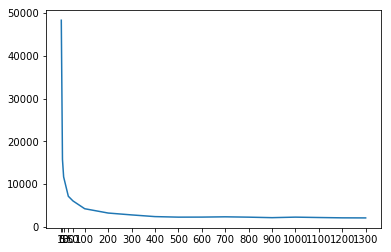

In [5]:
dd = df[df['numLines'] == 30]
data = dd.groupby('avgSlidingLen').median()
x = data.index.values
y = data['totalCost'].values
fig, ax = plt.subplots()
ax.plot(x,y)
_ = ax.set_xticks(x)

In [33]:
df.groupby(['avgSlidingLen', 'numLines']).std()

iterations1D  iterations3D     totalCost
avgSlidingLen numLines                                           
0             1              0.000000  2.022784e+06  2.022784e+06
              10             0.000000  1.910158e+05  1.910158e+05
              30             0.000000  6.824307e+04  6.824307e+04
              100            0.000000  2.112095e+04  2.112095e+04
5             1          22989.793886  6.866651e+05  8.015591e+05
              10          2350.837790  7.045186e+04  8.214740e+04
              30           807.098997  2.412950e+04  2.811561e+04
              100          228.923025  6.855910e+03  7.945768e+03
10            1          34584.044522  5.184692e+05  6.912931e+05
              10          3192.494122  4.759874e+04  6.346382e+04
              30          1085.909696  1.654912e+04  2.187652e+04
              100          306.252781  4.871306e+03  6.317469e+03
30            1          59140.914580  2.952238e+05  5.907179e+05
              10          5949.151713  2.961664e+04  5.918772e+04
              30          1996.217526  9.895537e+03  1.971090e+04
              100          560.930427  3.191902e+03  5.814630e+03
50            1          85450.302275  2.557656e+05  6.828123e+05
              10          8831.722821  2.648004e+04  7.042722e+04
              30          2640.755094  8.121894e+03  2.110558e+04
              100          735.570405  2.359341e+03  5.830123e+03
100           1         118618.546567  1.781238e+05  7.709432e+05
              10         11434.673693  1.727040e+04  7.419076e+04
              30          3784.154829  5.876189e+03  2.454690e+04
              100          968.113771  1.752558e+03  6.304102e+03
200           1         158530.378749  1.181593e+05  9.105111e+05
              10         15042.383660  1.121089e+04  8.610889e+04
              30          5179.060277  4.104640e+03  2.967208e+04
              100         1104.653521  1.093099e+03  6.284651e+03
300           1         226362.024803  1.145725e+05  1.246043e+06
              10         21376.343664  1.087004e+04  1.174236e+05
              30          7016.485314  3.704054e+03  3.846496e+04
              100         1349.704303  9.381585e+02  7.315709e+03

In [35]:
df.groupby(['avgSlidingLen', 'numLines']).mean()

iterations1D  iterations3D     totalCost
avgSlidingLen numLines                                           
0             1              0.000000  2.194467e+06  2.194467e+06
              10             0.000000  1.954303e+05  1.954303e+05
              30             0.000000  7.038168e+04  7.038168e+04
              100            0.000000  2.119021e+04  2.119021e+04
5             1          22307.341797  6.673907e+05  7.789274e+05
              10          2330.277344  6.991340e+04  8.156478e+04
              30           767.093750  2.311177e+04  2.694724e+04
              100          205.898438  6.441032e+03  7.470524e+03
10            1          33377.865234  4.998407e+05  6.667300e+05
              10          3199.767578  4.826229e+04  6.426112e+04
              30          1111.107422  1.705692e+04  2.261246e+04
              100          304.287109  4.990129e+03  6.511564e+03
30            1          59369.145508  2.964331e+05  5.932788e+05
              10          5849.847656  2.959813e+04  5.884737e+04
              30          1931.106445  9.924148e+03  1.957968e+04
              100          517.274414  3.035217e+03  5.621589e+03
50            1          80197.171875  2.403853e+05  6.413711e+05
              10          8350.024414  2.538228e+04  6.713240e+04
              30          2525.657227  7.957304e+03  2.058559e+04
              100          664.257812  2.355062e+03  5.676351e+03
100           1         116482.657227  1.747320e+05  7.571453e+05
              10         11379.940430  1.729704e+04  7.419674e+04
              30          3639.770508  5.772908e+03  2.397176e+04
              100          870.464844  1.654709e+03  6.007033e+03
200           1         156263.865234  1.172836e+05  8.986029e+05
              10         15363.478516  1.181475e+04  8.863214e+04
              30          4866.978516  4.007928e+03  2.834282e+04
              100          960.144531  1.067768e+03  5.868490e+03
300           1         218198.348633  1.095852e+05  1.200577e+06
              10         21853.321289  1.141233e+04  1.206789e+05
              30          6409.623047  3.555661e+03  3.560378e+04
              100         1244.507812  9.364980e+02  7.159037e+03

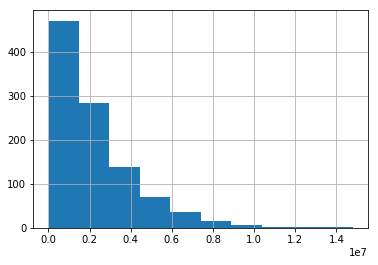

In [46]:
df[(df['avgSlidingLen'] ==0) & (df['numLines'] == 1)]['totalCost'].hist()